In [1]:
import flamp
import numpy as np
import numpy.linalg as lin
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import sparse
from tqdm import tqdm

import matrix_functions as mf

flamp.set_dps(50)  # compute with this many decimal digits precision


In [15]:
dim = 100
rng = np.random.default_rng(42)
lambda_min = 1
kappa = 1_000
lambda_max = kappa * lambda_min

# np.linspace(lambda_min, lambda_max, dim)
# a_diag = flamp.linspace(lambda_min, lambda_max, dim)
a_diag = flamp.to_mp(mf.generate_model_spectrum(dim, kappa, 0.9))

class DiagMatrix:
    def __init__(self, diag):
        self.diag = diag
        self.shape = (len(self), len(self))

    def __len__(self):
        return len(self.diag)

    def __matmul__(self, other):
        assert len(other) == len(self)
        return self.diag * other

    @property
    def dtype(self):
        return self.diag.dtype

# A = sparse.diags((a_diag), (0))  # this doesn't work with flamp
A = DiagMatrix(a_diag)

In [16]:
denom_deg = 2
def f(x):
    return x**(-denom_deg)
# f = flamp.sqrt # np.sqrt

In [17]:
x = flamp.to_mp(np.flip(mf.generate_model_spectrum(dim, kappa, 0.9)))  # flamp.ones(dim) # flamp.to_mp(rng.standard_normal(dim)) # should this just be the all ones vector??
ground_truth = mf.diagonal_fa(f, a_diag, x)
krylov_basis, _ = mf.lanczos(A, x, reorthogonalize=True)

In [18]:
ks = list(range(1, dim, 10))
lanczos_errors = []
krylov_errors = []
cheb_interpolant_errors = []
cheb_regression_errors = []

spectrum_discritization = mf.cheb_nodes(10*dim, a=lambda_min, b=lambda_max, dtype=np.dtype('O'))
f_spectrum_discritization = f(spectrum_discritization)
CV = mf.cheb_vandermonde(spectrum_discritization, dim+1)

for k, lanczos_estimate in tqdm(zip(ks, mf.lanczos_fa_multi_k(f, A, x, ks=ks, reorthogonalize=True))):
    lanczos_errors.append(mf.norm(lanczos_estimate - ground_truth, ord=np.inf))

    # _, squared_l2_error, _, _ = lin.lstsq(krylov_basis[:, :k], ground_truth, rcond=None)
    # krylov_errors.append(np.sqrt(squared_l2_error.item()))
    _, residual = flamp.qr_solve(krylov_basis[:, :k], ground_truth, res=True)
    krylov_errors.append(mf.norm(residual, ord=np.inf))

    # Degree of polynomial must be strictly less than dimension of Krylov subspace used in Lanczos (so k - 1)
    cheb_interpolant = mf.cheb_interpolation(k - 1, f, lambda_min, lambda_max, dtype=np.dtype('O'))
    cheb_interpolant_error = mf.norm(cheb_interpolant(spectrum_discritization) - f_spectrum_discritization, ord=np.inf)
    cheb_interpolant_errors.append(2 * mf.norm(x) * cheb_interpolant_error)

    cheb_coeffs = flamp.qr_solve(CV[:, :k], f_spectrum_discritization)
    # cheb_coeffs, _, _, _ = lin.lstsq(CV[:, :k], f_spectrum_discritization, rcond=None)
    cheb_regression_error = mf.norm(CV[:, :k] @ cheb_coeffs - f_spectrum_discritization, ord=np.inf)
    cheb_regression_errors.append(2 * mf.norm(x) * cheb_regression_error)

results = pd.DataFrame({
    "Number of matrix-vector products": np.array(ks) - 1,
    "Lanczos-FA": np.array(lanczos_errors, float),
    "Krylov subspace": np.array(krylov_errors, float),
    "Our bound": (kappa ** denom_deg) * np.array(krylov_errors, float),
    "Chebyshev interpolant $* 2||x||$": np.array(cheb_interpolant_errors, float),
    "Chebyshev regression $* 2||x||$": np.array(cheb_regression_errors, float)
})

relative_error = False
if relative_error:
    results.loc[:, results.columns != "Number of matrix-vector products"] /= mf.norm(ground_truth)

10it [00:21,  2.17s/it]


In [19]:
import scipy.special as sps

def tyler_inv_sqrt(q, a, b):
    # In the sidford paper, the approximation is valid in the range [gamma, 1]
    # that corresponds to [min(abs(lam)), max(abs(lam))] / max(abs(lam))
    # since sidford's gamma =tyler's sqrt(k2)

    # lmin = np.min(np.abs(lam))**2
    # lmax = np.max(np.abs(lam))**2
    assert 0 < a < b 
    lmin = a ** 2
    lmax = b ** 2

    poles = flamp.zeros(q)
    weights = flamp.zeros(q)

    k2 = lmin/lmax  # this is called gamma^2 in the Sidford paper
    Kp = sps.ellipk(1-k2)  # this is called K prime in the Sidford paper

    t = 1j*np.arange(1/2,q+1/2)*Kp/q

    sn_,cn_,dn_,_ = sps.ellipj(np.imag(t),1-k2) # compute real valued functions to transform to what we need

    cn = 1/cn_
    dn = dn_ / cn_
    sn = 1j * sn_ / cn_

    poles = np.real(lmin * sn**2)

    weights = (2 * Kp * flamp.sqrt(lmin))/(flamp.gmpy2.const_pi()*q) * (cn * dn)

    return lambda x: np.sum( weights / (x[:,None]-poles) ,axis=1)

In [7]:
# import baryrat

# running_best_rational_bound = np.inf
# best_rational_bounds = []
# for k in range(99):
#     if k >= 2:
#         ##### WARNING! DON"T HARD CODE THE FUNCTION OK!
#         # aaa_interpolant = baryrat.aaa(np.array(spectrum_discritization, float), np.sqrt, mmax=(k//2))
#         # error = mf.norm(aaa_interpolant(spectrum_discritization) - np.array(f_spectrum_discritization, float), ord=np.inf)
#         # deg_k_error = (kappa ** (k//2)) * error
#         inv_sqrt = tyler_inv_sqrt((k//2), spectrum_discritization.min(), spectrum_discritization.max())
#         zolotarev_interpolant = lambda x: 1./inv_sqrt(x)
#     else:
#         deg_k_error = np.inf

#     running_best_rational_bound = min(running_best_rational_bound, deg_k_error)
#     best_rational_bounds.append(running_best_rational_bound)

# results['rational'] = np.array([min(best_rational_bound[:(k+1)]) for k in ks], dtype=float)

In [8]:
# rational_bound_all_q = []
# for q in range(2,20):
#     rq_inv_sqrt = tyler_inv_sqrt(q, lambda_min, lambda_max)
#     rational_bound_q = []
#     for k in ks:
#         rational_approx_error = mf.norm(f(spectrum_discritization) - 1./rq_inv_sqrt(spectrum_discritization), ord=np.inf)
#         _, residual = flamp.qr_solve(krylov_basis[:, :k], mf.diagonal_fa(rq_inv_sqrt, a_diag, x), res=True) # uh-oh, this is 2-norm optimal, not A-norm optimal
#         krylov_error = mf.norm(residual, ord=np.inf)
#         rational_bound_q.append(rational_approx_error + (kappa ** q) * krylov_error)
#     rational_bound_all_q.append(rational_bound_q)

# results['other'] = np.array(rational_bound_all_q, float).min(axis=0)

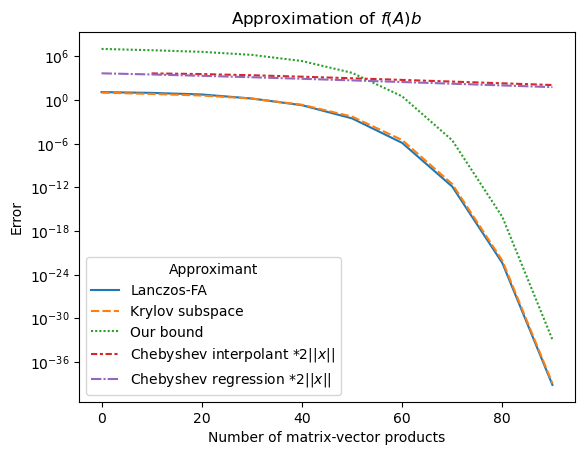

In [20]:
results_long = pd.melt(results, ["Number of matrix-vector products"], value_name="Error", var_name="Approximant")
sns.lineplot(x="Number of matrix-vector products", y=("Relative Error" if relative_error else "Error"), hue="Approximant", style="Approximant", data=results_long).set(
    title=f'Approximation of $f(A)b$',
    yscale='log'
);